In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
import sys
import networkx as nx

import geojson
from shapely.geometry import Polygon, Point
from shapely.prepared import prep

In [178]:
def bkg_img():

    plt.figure(figsize=(6, 4))
    bg_img = mpimg.imread('images/map_apple.png')
    ymin, xmin = [32.31, 34.44]
    ymax, xmax = [37.30, 42.77]
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.imshow(bg_img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

def bkg_blank():

    plt.figure(figsize=(6, 4))
    ymin, xmin = [32.31, 34.44]
    ymax, xmax = [37.30, 42.77]
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

### Cities and population data

https://data.humdata.org/dataset/hotosm_syr_populated_places

In [4]:
with open("data/populated_places/hotosm_syr_populated_places_points_geojson.geojson") as f: gj = geojson.load(f)
features = gj['features']

In [126]:
cities = {'Damascus' : [36.29 , 33.51],
          'Aleppo'   : [37.10 , 36.12],
          'Homs'     : [36.72 , 34.73],
          'Ar Raqqah': [39.01 , 35.95],
          'Idlib'    : [36.63 , 35.93],
          'Dayr az Zawr' : [40.14 , 35.34],
          'Latakia'  : [35.79 , 35.53],
          'Tartous'  : [35.89 , 34.89]}

100%|██████████| 8995/8995 [02:16<00:00, 65.66it/s] 


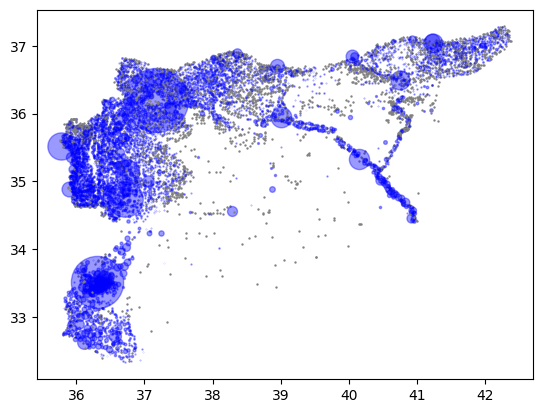

In [8]:
for elem in tqdm(features):
    x,y = elem['geometry']['coordinates']
    pop = elem['properties']['population']
    if isinstance(pop, str): 
        radius = int(pop)
        plt.scatter(x,y, s = radius/1000, c = 'blue', alpha = 0.4)
    else: plt.scatter(x,y, s = 0.5, c = 'grey')

In [ ]:
with open('data/populated_places/datafile.dat', 'w') as out:
    out.write("name population x y\n")  

    for elem in tqdm(features):
        name = elem['properties']['name:en']

        if not isinstance(name,str): continue

        x, y = elem['geometry']['coordinates']
        pop  = elem['properties']['population']

        try:
            if isinstance(pop, str):
                pop_clean = int(pop.split()[0])
            else:
                pop_clean = int(pop)
        except (ValueError, TypeError):
            pop_clean = 0

        out.write(f"{name} {pop_clean} {x} {y}\n")

100%|██████████| 8995/8995 [00:00<00:00, 205766.86it/s]


In [ ]:
with open('data/populated_places/datafile_reduced.dat', 'w') as out:
    out.write("name population x y\n") 

    for elem in tqdm(features):
        name = elem['properties']['name:en']

        if not isinstance(name,str): continue

        x, y = elem['geometry']['coordinates']
        pop  = elem['properties']['population']

        if not isinstance(pop,str): continue

        try:
            if isinstance(pop, str):
                pop_clean = int(pop.split()[0])
            else:
                pop_clean = int(pop)
        except (ValueError, TypeError):
            pop_clean = 0

        out.write(f"{name} {pop_clean} {x} {y}\n")

100%|██████████| 8995/8995 [00:00<00:00, 151365.76it/s]


0it [00:00, ?it/s]

8010it [01:49, 73.46it/s] 


Text(0, 0.5, 'Latitude')

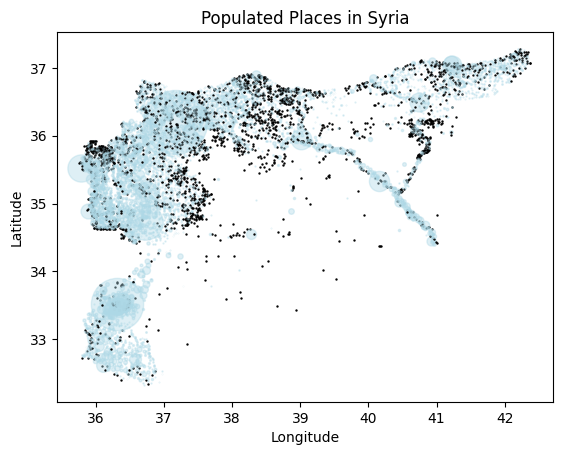

In [ ]:
with open('data/populated_places/datafile.dat') as f:

    next(f)  
    for line in tqdm(f):

        *name, pop_str, x_str, y_str = line.strip().split()
        pop = int(pop_str)
        x = float(x_str)
        y = float(y_str)

        if pop > 0:
            plt.scatter(x, y, s=pop / 1000, c='lightblue', alpha=0.4)
        else:
            plt.scatter(x, y, s=0.5, c='black')

plt.title("Populated Places in Syria")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

#### Geometrical distance network

In [ ]:
n = 8010
adj_geom = np.zeros((n,n))

with open('data/populated_places/datafile.dat') as f:
    next(f) 

    content = f.readlines()
    for i in tqdm(range(len(content))):
        for j in range(len(content)):
            if j <= i: continue

            *_, x_str_1, y_str_1 = content[i].strip().split()
            *_, x_str_2, y_str_2 = content[j].strip().split()
            x1 = float(x_str_1)
            y1 = float(y_str_1)
            x2 = float(x_str_2)
            y2 = float(y_str_2)

            dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)
            adj_geom[i][j] = dist

adj_geom = 0.5*(adj_geom + adj_geom.T)
np.savetxt('adj_geom.txt', adj_geom, fmt='%.3f')

In [135]:
pos = {}

with open('data/populated_places/datafile.dat') as f:
    next(f) 

    content = f.readlines()
    for i in tqdm(range(len(content))):
        *_, x_str, y_str = content[i].strip().split()
        x = float(x_str)
        y = float(y_str)

        pos[i] = (x,y)

100%|██████████| 8010/8010 [00:00<00:00, 60303.23it/s]


In [137]:
adj_geom = np.loadtxt("adj_geom.txt")
n = adj_geom.shape[0]
thr = 0.1
adj_lim = adj_geom.copy()
adj_lim[adj_lim > thr] = 0

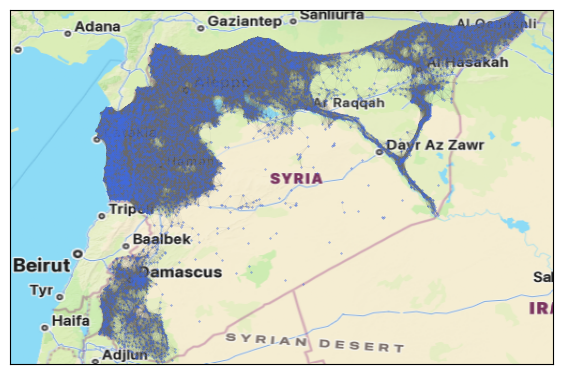

In [ ]:
nlim = n
G_geom = nx.from_numpy_array(adj_lim[:nlim,:nlim])
pos_small = {k: pos[k] for k in list(pos)[:nlim]}

bkg_img()

nx.draw_networkx(G_geom, pos_small, width = 0.03, with_labels=False, node_color='royalblue', edge_color='dimgrey', node_size=0.1)
plt.savefig(f'images/geo_network.png', bbox_inches = 'tight', dpi=300)

#### Oil & gas reserves/infrastructure

https://www.energy-cg.com/MiddleEast/Syria/Syria%20Oil%20and%20Gas%20Overview.html#Syrian%20Oil%20and%20Gas%20Overview%20Map

https://www.atlanticcouncil.org/in-depth-research-reports/issue-brief/syrias-energy-sector-and-its-impact-on-stability-and-regional-developments/

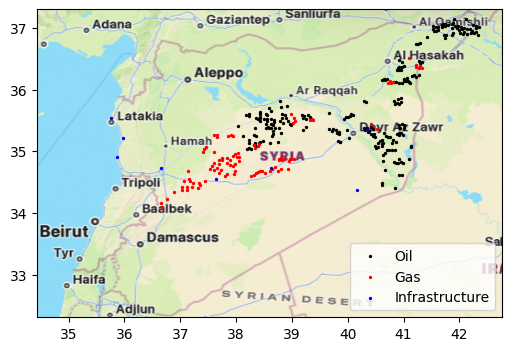

In [116]:
f = open(f"data/oil_gas/oil_coords.txt", "r")
content = f.readlines()
f.close()
    
x_oil = []
y_oil = []
for line in content:
    temp1 = float(line.split()[0].replace(',', ''))
    temp2 = float(line.split()[1].replace(',', ''))
    x_oil += [temp1]
    y_oil += [temp2]
    
f = open(f"data/oil_gas/gas_coords.txt", "r")
content = f.readlines()
f.close()
    
x_gas = []
y_gas = []
for line in content:
    temp1 = float(line.split()[0].replace(',', ''))
    temp2 = float(line.split()[1].replace(',', ''))
    x_gas += [temp1]
    y_gas += [temp2]

f = open(f"data/oil_gas/infra_coords.txt", "r")
content = f.readlines()
f.close()
    
x_infra = []
y_infra = []
for line in content:
    temp1 = float(line.split()[0].replace(',', ''))
    temp2 = float(line.split()[1].replace(',', ''))
    x_infra += [temp1]
    y_infra += [temp2]

bkg_img()

plt.scatter(x_oil, y_oil, c = 'black', s = 2, label = 'Oil')
plt.scatter(x_gas, y_gas, c = 'red', s = 2, label = 'Gas')
plt.scatter(x_infra, y_infra, c = 'blue', s = 2, label = 'Infrastructure')
plt.legend(loc = 4)
plt.savefig(f'images/oil_gas_infra.png', bbox_inches = 'tight', dpi=300)

Assign 'oil score'

100%|██████████| 8010/8010 [00:28<00:00, 279.67it/s]


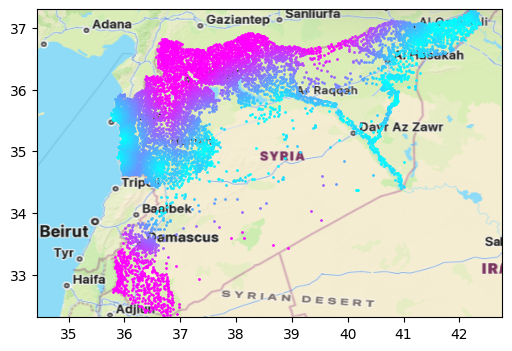

In [117]:
output_file = 'data/populated_places/datafile_oilscore.dat'
oilscores = []

bkg_img()

with open('data/populated_places/datafile.dat') as f, open(output_file, 'w') as fout:
    header = f.readline().strip()
    fout.write(header + " oil_score\n")

    content = f.readlines()
    for line in tqdm(content):

        *_ , x_str, y_str = line.strip().split()
        x = float(x_str)
        y = float(y_str)

        min_d_sq_oil = np.min((np.array(x_oil) - x)**2 + (np.array(y_oil) - y)**2)
        min_d_sq_gas = np.min((np.array(x_gas) - x)**2 + (np.array(y_gas) - y)**2)
        min_d_sq_infra = np.min((np.array(x_infra) - x)**2 + (np.array(y_infra) - y)**2)

        score_sq = np.min(np.array([min_d_sq_oil, min_d_sq_gas, min_d_sq_infra]))
        oil_score = np.sqrt(score_sq)
        oilscores += [oil_score]
        fout.write(line.strip() + f" {oil_score:.3f}\n")

        col = oil_score
        plt.scatter(x,y, s=1, color = cm.cool(col))

plt.savefig(f'images/dist_to_resources.png', bbox_inches = 'tight', dpi=300)

### Ethnic minorities

Info: https://minorityrights.org/country/syria/

https://www.heritageforpeace.org/syria-country-information/geography/

https://commons.wikimedia.org/wiki/File:Syria_Ethnoreligious_Map.png

In [118]:
titles = np.array(['alawites','sunni','kurds1','kurds2','kurds3'])

def minority_region(region_title):

    f = open(f"data/minorities/{region_title}.txt", "r")
    content = f.readlines()
    f.close()
        
    coords = []
    for line in content:
        temp1 = float(line.split()[0].replace(',', ''))
        temp2 = float(line.split()[1].replace(',', ''))
        coords += [(temp1,temp2)]
        
    polygon = Polygon(coords)
    return prep(polygon)  

polygons = {title: minority_region(title) for title in titles}

cols = {'alawites': 'lime',
        'sunni'   : 'navy',
        'kurds1'  : 'goldenrod',
        'kurds2'  : 'goldenrod',
        'kurds3'  : 'goldenrod'}


100%|██████████| 8010/8010 [00:30<00:00, 266.02it/s]


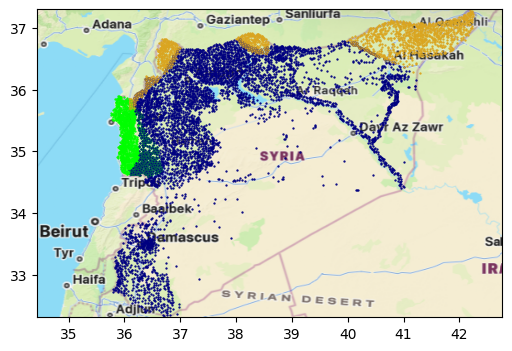

In [119]:
output_file = 'data/populated_places/datafile_oilscore_minorities.dat'
bkg_img()

with open('data/populated_places/datafile_oilscore.dat') as f, open(output_file, 'w') as fout:
    header = f.readline().strip()
    fout.write(header + " minorities\n") 

    content = f.readlines()
    for line in tqdm(content):

        *_ , x_str, y_str, _ = line.strip().split()
        x = float(x_str)
        y = float(y_str)

        fout.write(' '.join(line.strip().split()[-4:]))

        for titl in titles:
            res = polygons[titl].contains(Point(x,y))
            if res==True:
                if titl=='kurds1' or titl=='kurds2' or titl=='kurds3':
                    fout.write(f" kurds")
                if titl=='alawites':
                    fout.write(f" state")   # for later convenience
                if titl=='sunni':
                    fout.write(f" sunni")  
                plt.scatter(x,y, s=0.4, color = cols[titl])

        fout.write("\n")
                
plt.savefig(f'images/minorities.png', bbox_inches = 'tight', dpi=300)

### Initial distribution

16 March 2019 https://www.youtube.com/watch?v=ToxfSPfbx2E

In [120]:
names = np.array(['state1','state2','state3','sunni_mask'])

def init_region(name_title):

    f = open(f"data/initial/init_{name_title}.txt", "r")
    content = f.readlines()
    f.close()
        
    coords = []
    for line in content:
        temp1 = float(line.split()[0].replace(',', ''))
        temp2 = float(line.split()[1].replace(',', ''))
        coords += [(temp1,temp2)]
        
    polygon = Polygon(coords)
    return prep(polygon)  

polygons_init = {nam: init_region(nam) for nam in names}

100%|██████████| 8010/8010 [00:00<00:00, 13671.57it/s]


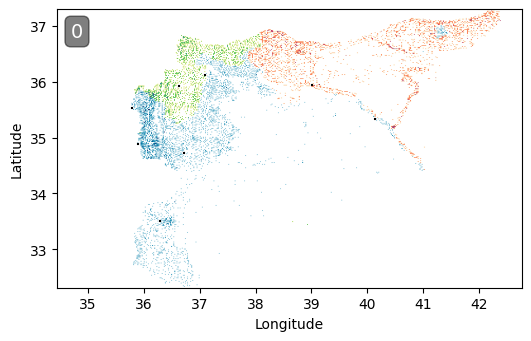

In [179]:
bkg_blank()

x_state, y_state = [[],[]]
x_sunni, y_sunni = [[],[]]
x_kurds, y_kurds = [[],[]]

with open('data/populated_places/datafile_oilscore.dat') as f, open('data/initial/init_occupier.dat','w') as fout:
    next(f)
    fout.write("initial_occupier\n") 

    content = f.readlines()
    for line in tqdm(content):

        *_ , x_str, y_str, _ = line.strip().split()
        x = float(x_str)
        y = float(y_str)

        res1 = polygons_init['state1'].contains(Point(x,y)) or polygons_init['state2'].contains(Point(x,y)) or polygons_init['state3'].contains(Point(x,y))
        if res1==True:
            x_state += [x]
            y_state += [y]
            fout.write('state')

        else:
            res2 = polygons_init['sunni_mask'].contains(Point(x,y)) 
            if res2==True:
                x_sunni += [x]
                y_sunni += [y]
                fout.write('sunni')
            else:
                x_kurds += [x]
                y_kurds += [y]
                fout.write('kurds')

        fout.write('\n')

heatmap, xedges, yedges = np.histogram2d(x_state, y_state, bins=300)
plt.imshow( heatmap.T, origin='lower', cmap='ocean_r', 
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], alpha = 1
)

heatmap, xedges, yedges = np.histogram2d(x_sunni, y_sunni, bins=200)
plt.imshow( heatmap.T, origin='lower', cmap='viridis_r_alpha', 
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], alpha = 1
)

heatmap, xedges, yedges = np.histogram2d(x_kurds, y_kurds, bins=200)
plt.imshow( heatmap.T, origin='lower', cmap='magma_r_alpha', 
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], alpha = 1
)

for city in cities:
    plt.scatter(cities[city][0],cities[city][1],c='black',s=1,marker='+')


plt.text(
        0.03, 0.9, f"{0}",
        transform=plt.gca().transAxes,
        fontsize=14, color='white',
        bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3')
    )

plt.savefig(f'images/frames/frame_0.png', bbox_inches = 'tight', dpi=300)


In [127]:
# get colormap
mname = 'magma_r'
ncolors = 256
color_array = plt.get_cmap(mname)(range(ncolors))
# change alpha values
nlim = 30
color_array[:nlim,-1] = np.linspace(0.0,1.0,nlim)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name=f'{mname}_alpha',colors=color_array)

# register this new colormap with matplotlib
#plt.colormaps.register(cmap=map_object)

# show some example data
#f,ax = plt.subplots()
#h = ax.imshow(np.random.rand(100,100),cmap=map_object)
#plt.colorbar(mappable=h)

### Betweenness centrality

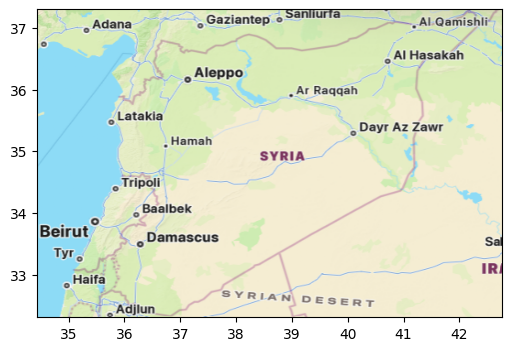

In [ ]:
G_geom = nx.from_numpy_array(adj_lim)
bkg_img()

#BCE = nx.betweenness_centrality(G_geom)

#nx.draw_networkx(G_geom, pos, width = 0.03, with_labels=False, node_color='royalblue', edge_color='dimgrey', node_size=0.1)

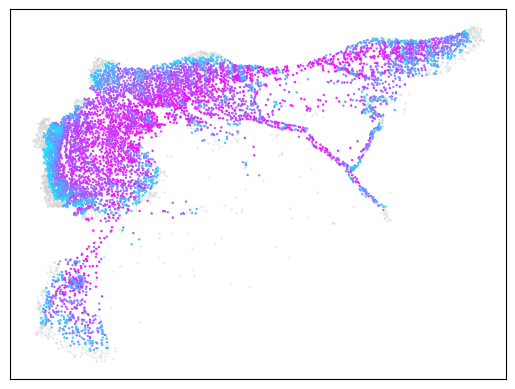

In [188]:
bce_cut = 0.0001


high_bce_nodes = [n for n, v in BCE.items() if v > bce_cut]
col = [cm.cool(np.arctan(2000*v)/(np.pi/2)) for n,v in BCE.items() if v > bce_cut]

nx.draw_networkx_nodes(G_geom, pos, node_color="lightgray", node_size=0.1)
nx.draw_networkx_nodes(G_geom, pos, nodelist=high_bce_nodes, node_color=col, node_size=0.4)

#nx.draw_networkx_edges(G, pos, alpha=0.5)

In [163]:
with open("data/betweenness_centrality/bce_values.txt", "w") as f:
    f.write('betweenness_centrality\n')
    for value in BCE.values():
        f.write(f"{value}\n")